In [5]:
!pip install geopandas
!pip install seaborn
!pip install networkx

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.2 MB 4.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.6/16.2 MB 3.8 MB/s eta 0:00:04
   ----- ---------------------------------- 2.1/16.2 MB 3.9 MB/s eta 0:00:04
   ------- -------------------------------- 3.1/16.2 MB 3.8 MB/s eta 0:00:04
   ---------- ----------------------------- 4.2/16.2 MB 4.1 MB/s eta 0:00:03
   ------------ --------------------------- 5.0/16.2 MB 4.2 MB/s eta 0:00:03
   ------------- -------------------------- 5.5/16.2 MB 3.8 MB/s eta 0:00:03
   --------------- ------------------------ 6.3/16.2 MB 3.9 MB/s eta 0:00:03
   ------------------- -------------------- 7.9/16.2 MB 4.2 MB/s eta 0:00:02
   --------------------- ------------------ 8.7/16.2 MB 4.3 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.2 MB 4.4 MB/s eta 0:00:02
   --------------------------- ------------ 11.3/16.2 MB 4.5 MB/s eta 0:00:02
   -

In [7]:
# Carga de paquetes necesarios para graficar

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [10]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

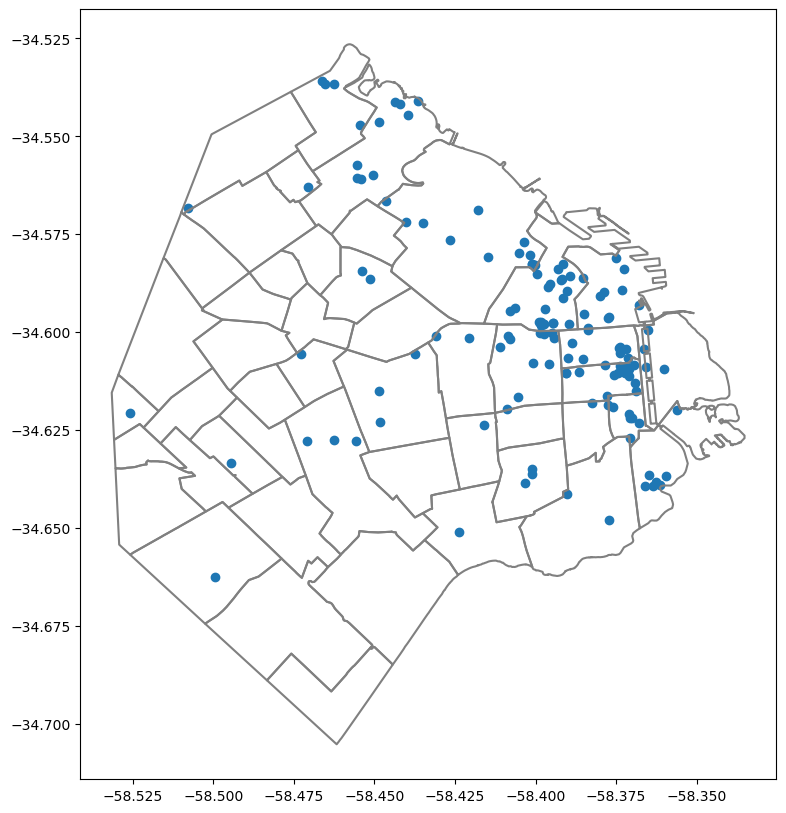

In [13]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [15]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [129]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [132]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

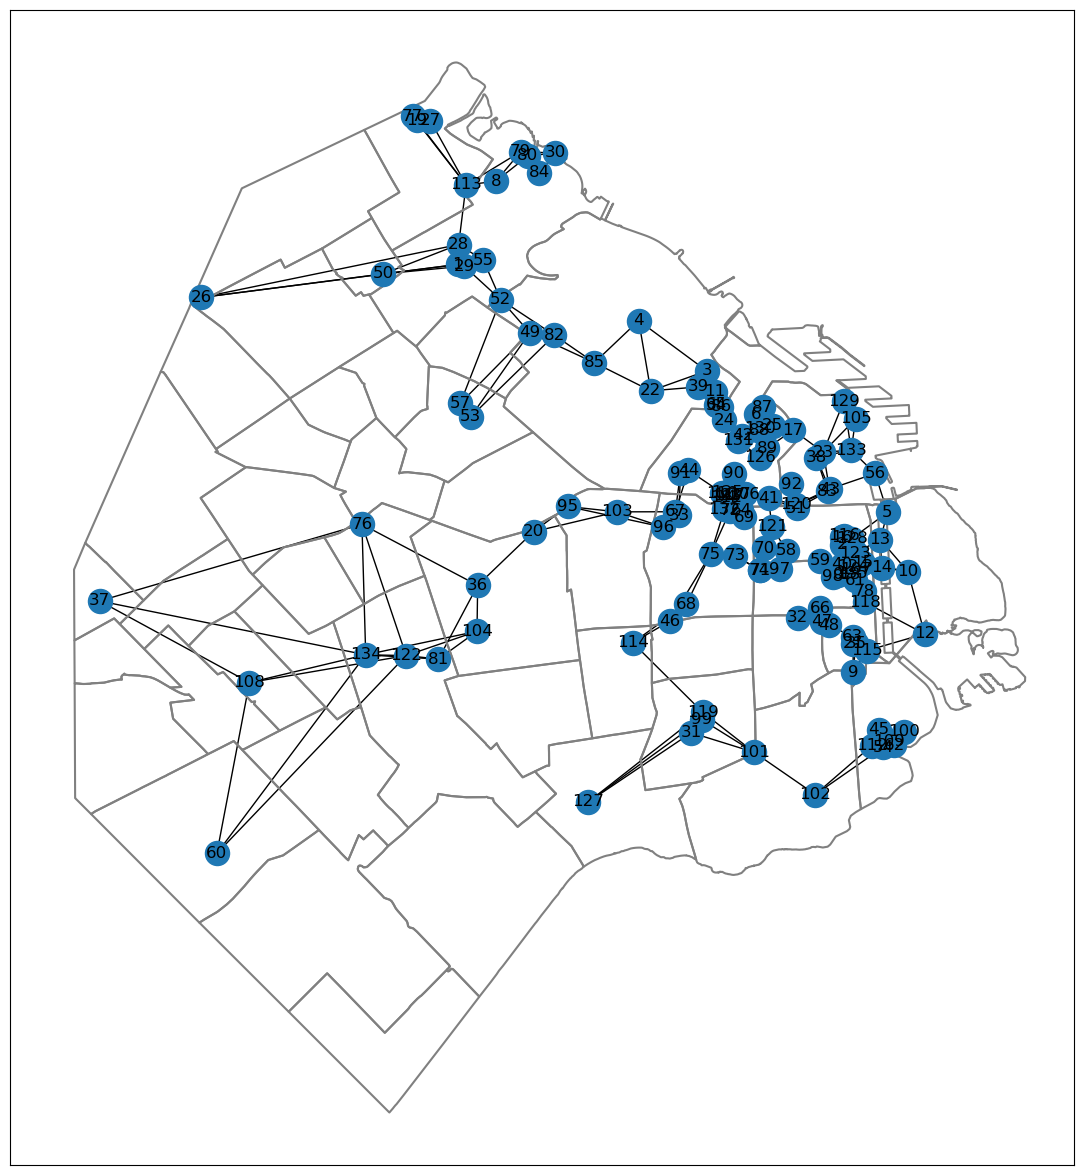

In [134]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:
Buscamos llegar a $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$  

Partimos de la ecuacion de $p = (1 - \alpha) C p + \frac{\alpha}{N} 1$  

Ahora pasamos restando el termino  $(1 - \alpha) C p$  para el otro lado entonces nos queda la ecuacion: $p - (1 - \alpha) C p = \frac{\alpha}{N} 1$  

Luego sacamos Factor Comun P y nos queda la siguiente ecuacion:  $ (I-(1 - \alpha)C) p = \frac{\alpha}{N} 1$

Por ultimo pasamos diviendo el termino $\frac{\alpha}{N}$ y obtenemos lo siguiente: $  \frac{N}{\alpha} (I-(1 - \alpha)C) p = 1$

Y de esa manera conseguimos lo que buscabamos Mp=b con $M = \frac{N}{\alpha} (I - (1 - \alpha) C)$ y $b=1$ 



## Punto 2:
Las condicion que se deben cumplir es basicamente que la matriz M sea inversible y eso se puede ver de varias maneras:

**1**.Determinante de la matriz debe ser distinto de 0  
**2**.Las filas de la matriz tienen que ser Linealmente Independientes  
**3**.El nucleo tiene que ser solo el 0


## Punto 3:

In [103]:

from scipy.linalg import solve_triangular
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

def calculaLU(A):
    m=A.shape[0]
    n=A.shape[1]
    Ac = A.copy()
    if m!=n:
        print('Matriz no cuadrada')
        return
    L=np.eye(n)
    U=Ac
    for j in range(n):
        for i in range(j+1,n):
            L[i,j]=U[i,j]/U[j,j]
            U[i,:]=U[i,:]-L[i,j]*U[j,:]
    return L, U

def calcula_matriz_C(A): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C
    n=A.shape[0]
    
    At=np.transpose(A)
    
    k=np.eye(n)
    for i in range(n):
        v=0
        for j in range(n):
            v+=A[i,j]
        k[i,i]=v
    Kinv = np.eye(n) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A
    for i in range(n):
        Kinv[i,i] = 1/k[i,i]
    C = Kinv@At # Calcula C multiplicando Kinv y A
    return C

    
def calcula_pagerank(A,alfa):
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el número de museos N a partir de la estructura de la matriz A
    I = np.eye(N)
    M = (N/alfa)*(I-(1-alfa)*C)
    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d
    b = np.empty(A.shape[0]) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    b.fill(alfa/N)
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    return p
def grafico(D,m,alfa):
    A = construye_adyacencia(D, m)

    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    pr = calcula_pagerank(A,alfa)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    Nprincipales = 3 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres
    



## Punto 3)a)

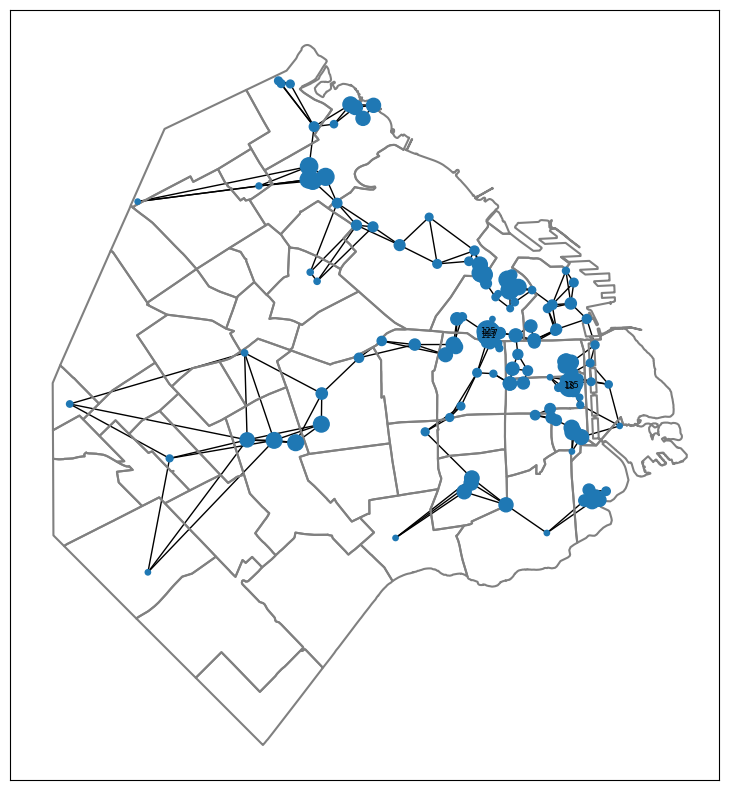

In [89]:

grafico(D,3,1/5)

## Punto 3)b)

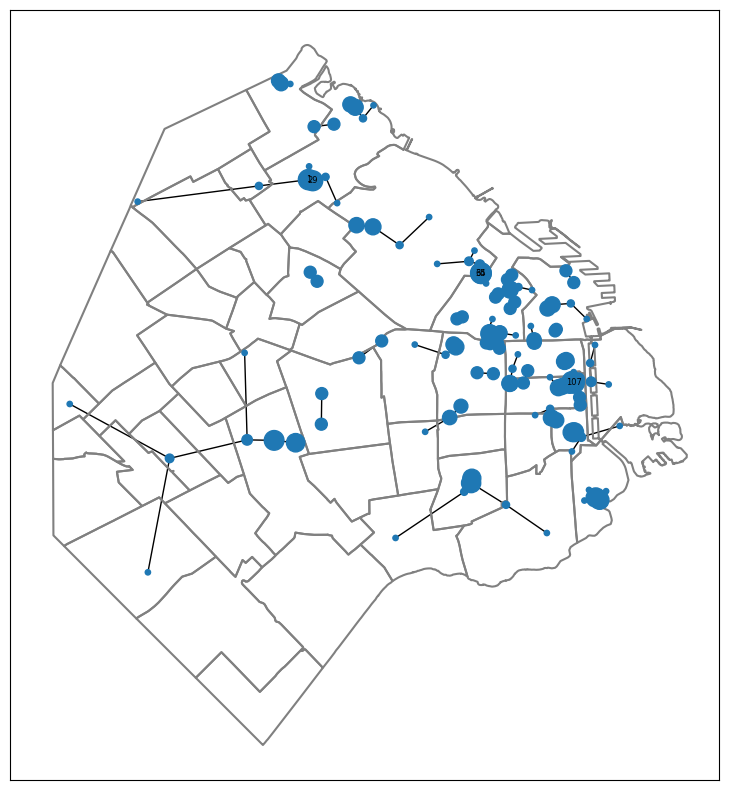

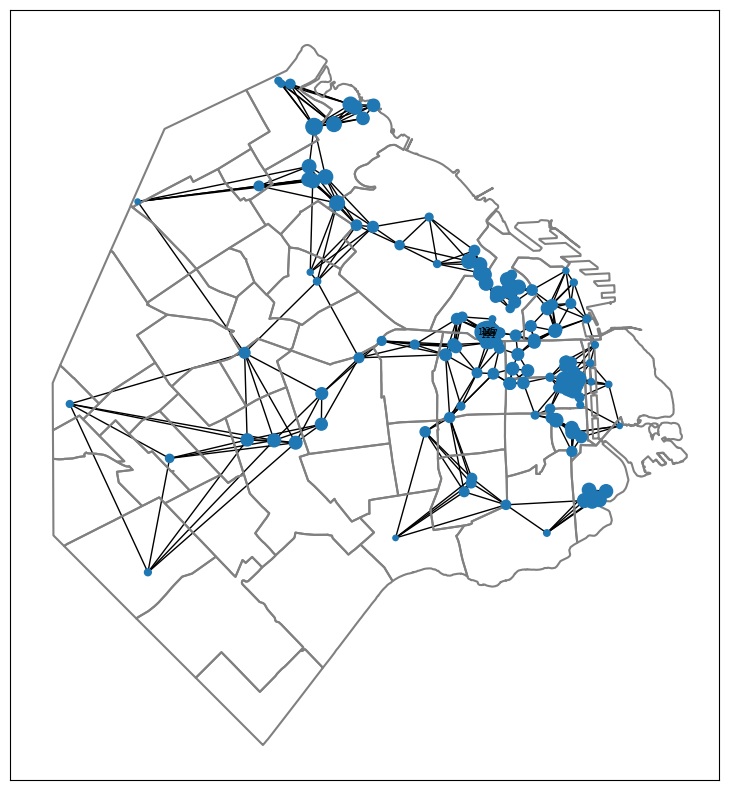

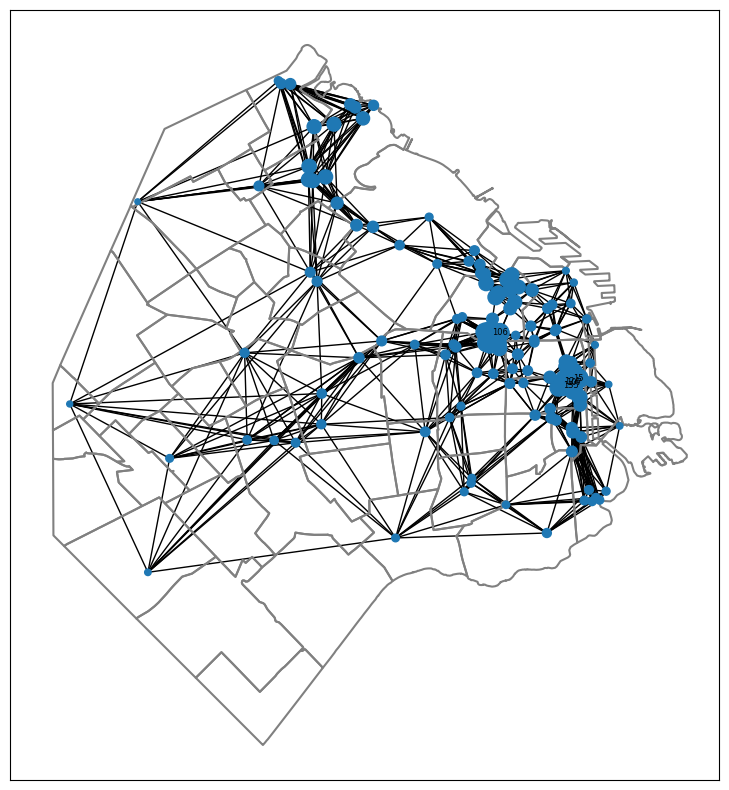

In [91]:
grafico(D,1,1/5)
grafico(D,5,1/5)
grafico(D,10,1/5)


## Punto 3)c)

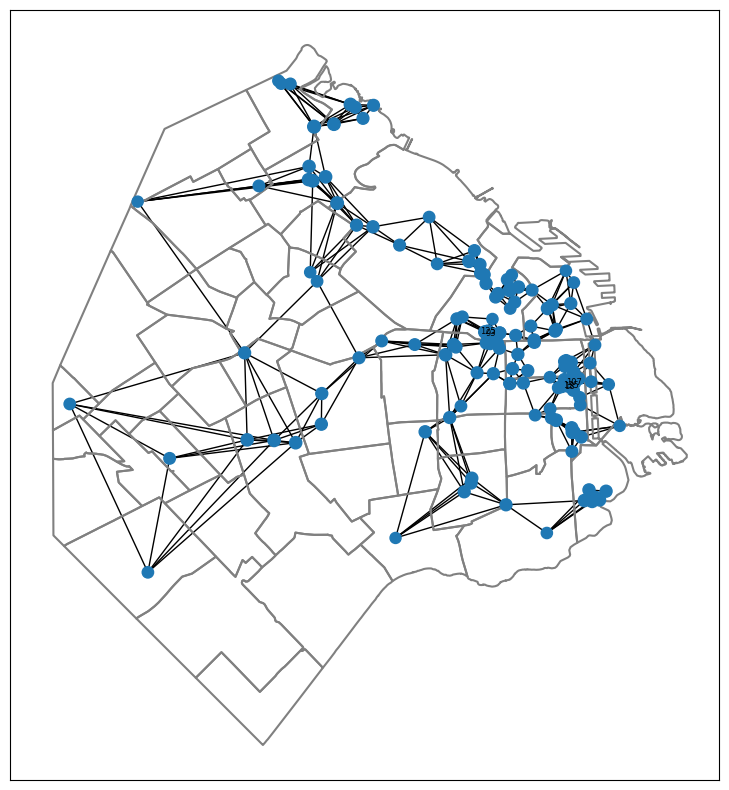

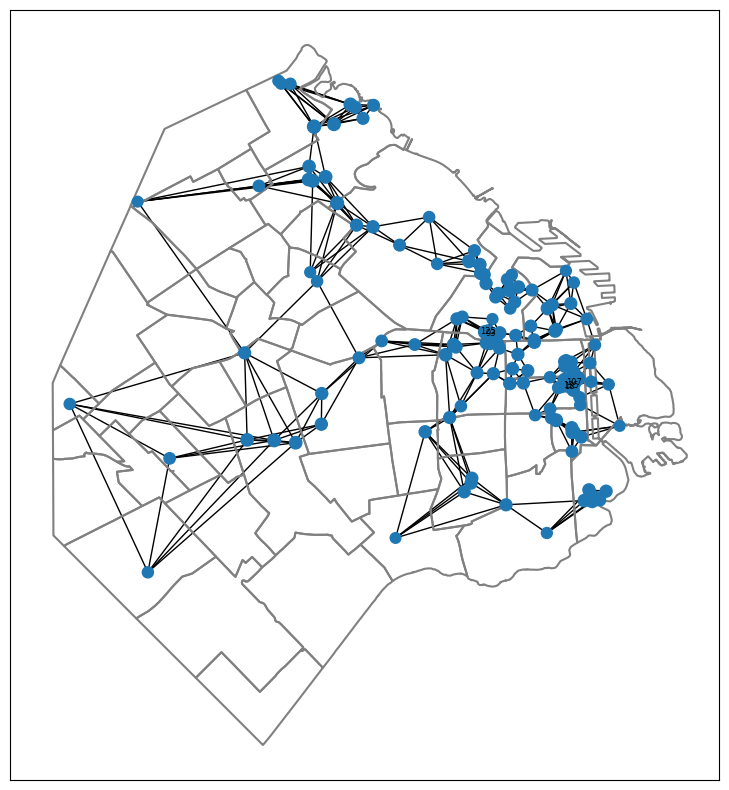

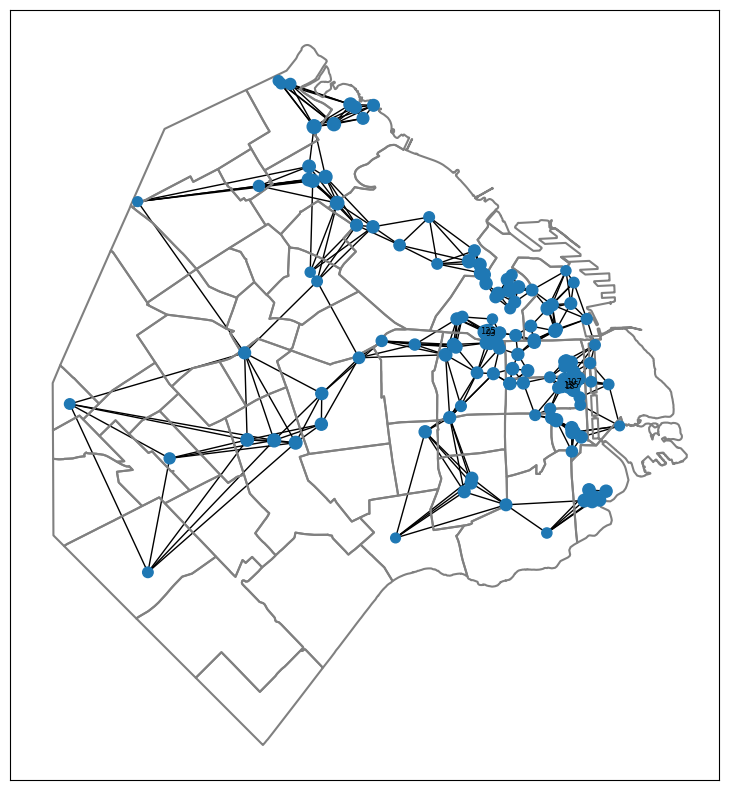

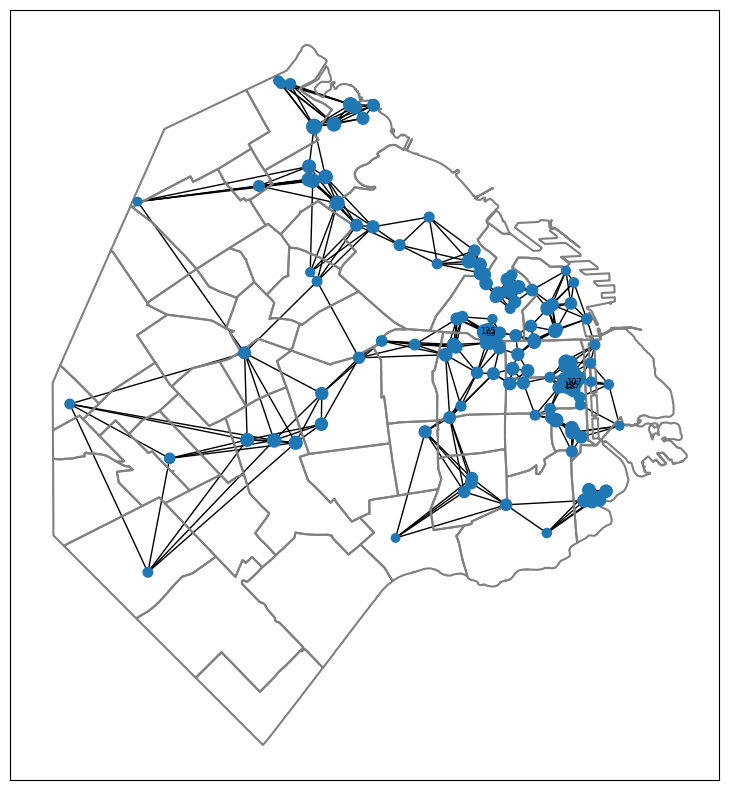

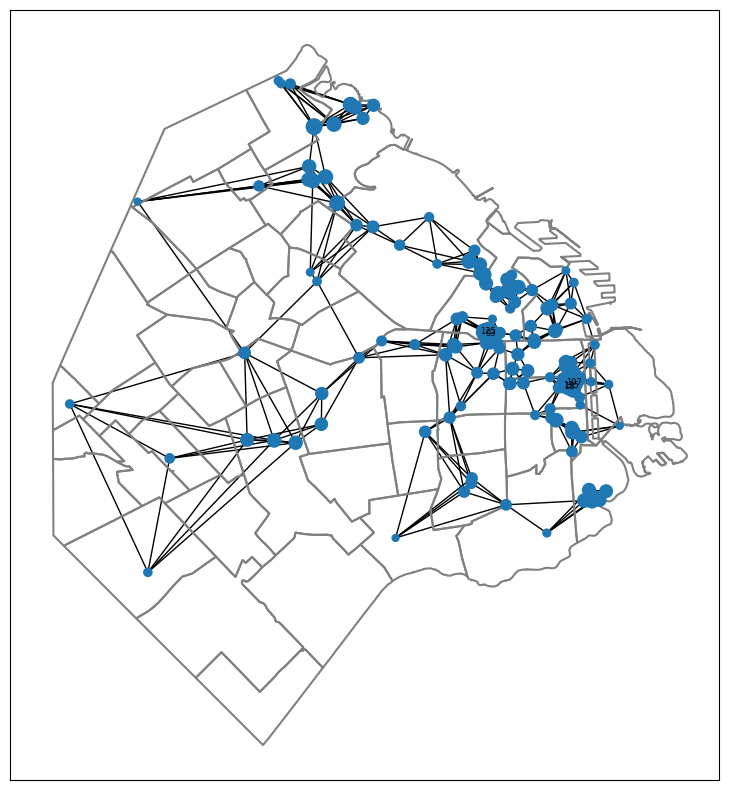

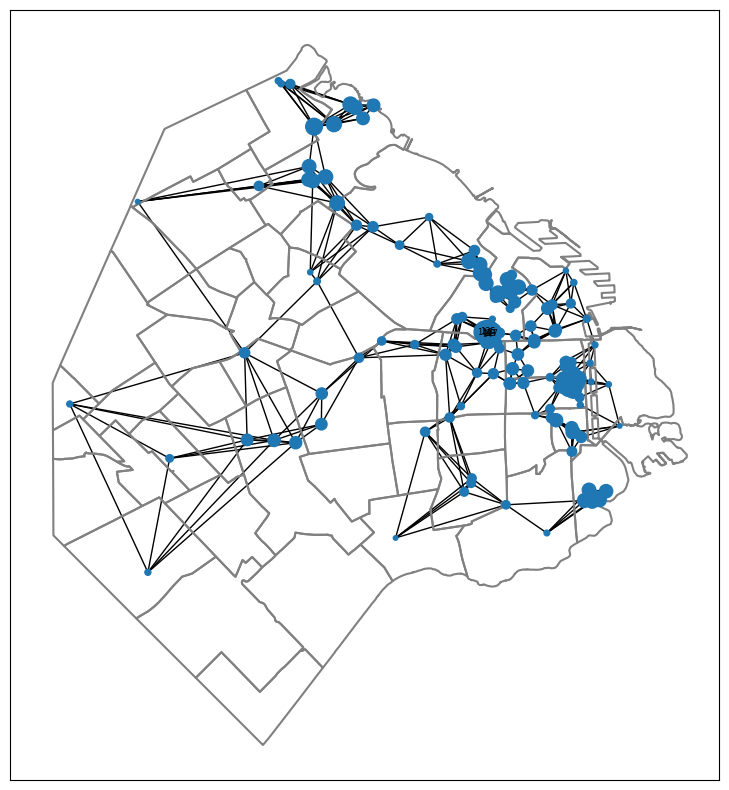

In [93]:
grafico(D,5,6/7)
grafico(D,5,4/5)
grafico(D,5,2/3)
grafico(D,5,1/2)
grafico(D,5,1/3)
grafico(D,5,1/7)

## Punto 3)a)a)

## Punto 3)b)b)


## Punto 4:
Para este punto partimos de la ecuacion:  
$$\mathbf{v} = B^{-1} \mathbf{w}$$ siendo **w** el vector que en cada componente tiene la cantidad total de visitantes por museo y $B = \sum_{k=0}^{r-1} C_k$  

Se busca probar que **v** es el vector que tiene en cada componente la cantidad de personas que tuvieron ese museo como entrada.  

Asumiendo que B es inversible podemos llegar a la siguiente ecuacion: $$\mathbf{v} B = \mathbf{w}$$

De aca tomamos B generica: ($C_0+C_1+C_2+...+C_k$) y  tambien el **w** generico: ($w_0,w_1,w_2,...,w_i$)

Si ahora hacemos el producto de B por **v**=$v_0$ obetenemos el siguiente resultado: ($v_0*C_0+v_0*C_1+v_0*C_2+...+v_0*C_k$)  

Y por ultimo igualamos ambos vectores ($v_0*C_0+v_0*C_1+v_0*C_2+...+v_0*C_k$) = ($w_0,w_1,w_2,...,w_i$)  

Para que esa igualdad se cumpla tienen que ser iguales coordenada a coordenada entonces se obtiene:  
                                    $$(v_0*C_0=w_0), (v_0*C_1=w_1), (v_0*C_2=w_2) ,..., (v_0*C_k=w_i)$$  
De esa manera se consigue probar lo que queriamos ya que usando que **v** tiene las perosnas que ingresaron a traves de un museo, luego de k pasos se puede obtener la cantidad de visitantes haciendo $v_0*C_k$, que es justamente lo que nos da la ecucion de arriba para cada museo el total de visitantes esta deifinido por esa ecuacion que fue demostrada                                 
                                    


## Punto 5:

In [107]:
def calcula_matriz_C_continua(D): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versión continua
    D = D.copy()
    F = 1/D
    np.fill_diagonal(F,0)

    n=D.shape[0]
    k=np.eye(n)
    for i in range(n):
        v=0
        for j in range(n):
            v+=D[i,j]
        k[i,i]=v
    Kinv = np.eye(n) 
    for i in range(n):
        Kinv[i,i] = 1/k[i,i] # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de F 
    C = Kinv@F # Calcula C multiplicando Kinv y F
    return C

def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    n = C.shape[0]
    B = np.eye(n)*0
    for i in range(cantidad_de_visitas-1):
        cm = C.copy()# Sumamos las matrices de transición para cada cantidad de pasos
        for j in range(i):
            cm = cm@C
        B+=cm
    return B

#punto5
w = np.loadtxt("visitas.txt")
def ecuacion5(D): 
    C=calcula_matriz_C_continua(D)   
    B=calcula_B(C,3)
    L,U=calculaLU(B)
    y = scipy.linalg.solve_triangular(L,w,lower=True) 
    v = scipy.linalg.solve_triangular(U,y)
    return v

ecuacion5(D)
    
    

C:\Users\Guille\AppData\Local\Temp\ipykernel_15140\2053013201.py:6: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


array([ 1.47740906e+10, -7.41731139e+09,  1.27654460e+09,  5.13062821e+10,
        5.58121076e+11,  2.23506814e+11,  3.99273016e+10,  9.70679890e+08,
        9.35322506e+10,  4.41120012e+11, -2.93163384e+11, -1.12608720e+11,
       -1.38091931e+11,  3.34366527e+10, -1.80891233e+11, -1.65621215e+10,
       -1.59613860e+10, -8.20421647e+09, -2.69248490e+10,  4.05651452e+10,
       -2.22619998e+11, -7.11390923e+10,  3.44517187e+11, -3.25413034e+10,
       -2.11121150e+11,  2.26600266e+10, -2.31167420e+10, -1.66658470e+10,
        3.69376558e+10, -1.57237642e+10, -2.14156741e+11,  1.26070249e+10,
        8.61137428e+09,  1.87930825e+11,  2.50028574e+10, -6.14307984e+10,
        3.20706221e+12,  4.28810968e+12, -4.46753087e+10,  6.20191553e+09,
        2.88511853e+10, -1.04283779e+11,  4.92483307e+10, -9.95518009e+09,
        8.81705128e+10,  1.24824832e+11, -1.79921147e+11, -4.18149312e+10,
       -2.92945404e+10, -2.50577818e+11,  3.28793070e+11,  2.57966464e+10,
       -2.06126557e+11, -

## Punto 6:

In [109]:
def ecuacion(D):
    C=calcula_matriz_C_continua(D)   
    B=calcula_B(C,3)
    numero_condicionB=np.linalg.cond(B,1)
    error=0.05
    error_estimadoV=numero_condicionB*error
    return error_estimadoV
ecuacion(D)


C:\Users\Guille\AppData\Local\Temp\ipykernel_15140\2053013201.py:6: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


5705.429133598459

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

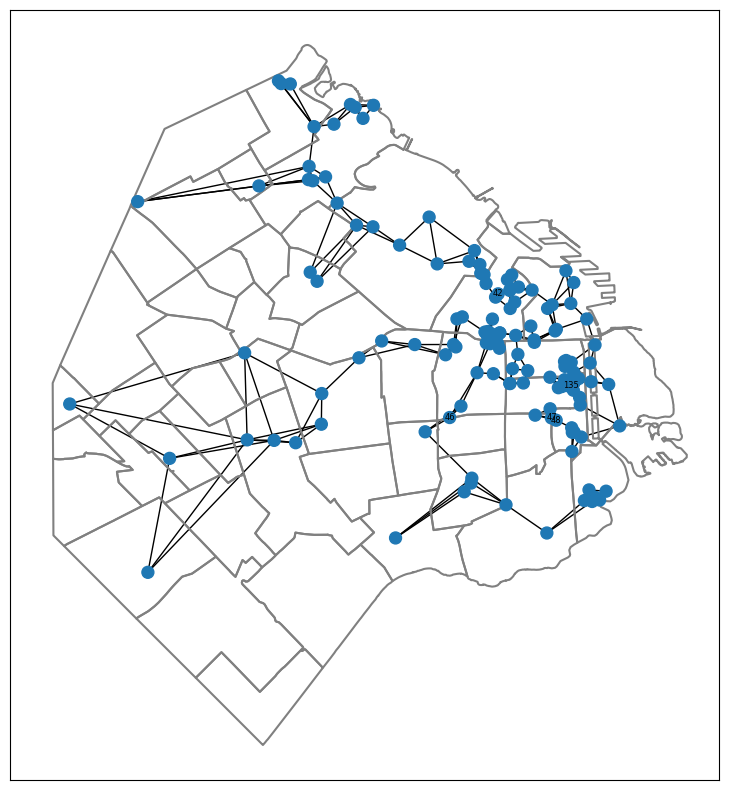

In [61]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = calcula_pagerank(A,1)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres